# Credit Risk Assessment with ML Models

This example demonstrates credit risk modeling using both **logistic regression** and **decision trees**. 

Both models are commonly applied in credit loan applications:
- **Logistic Regression**: Provides a simple and interpretable way to identify borrowers at risk of default.
- **Decision Trees**: Captures more nuanced relationships and interactions between borrower characteristics, potentially uncovering patterns logistic regression may miss.

These models offer complementary insights and will be used in this example to compare performance and interpretability in predicting loan defaults. While the example focuses on the ML concepts and uses synthetic data, you may easily substritute synthetic with real data.

Let me break down the key components:

1. Data Preparation
    - Creates synthetic credit data with realistic features
    - Includes important factors like income, credit score, debt-to-income ratio
    - Demonstrates proper data splitting and scaling techniques
2. Model Implementation
    - Implements both logistic regression and decision tree models
    - Shows how to handle binary classification problems (0 or 1, true or false, yes or no, default or no-default, etc...)
    - Demonstrates proper model training procedures
3. Evaluation and Analysis
    - Includes comprehensive model evaluation metrics
    - Creates visualization for confusion matrices
    - Analyzes and compares feature importance between models
4. Practical Application
    - Includes a function for making predictions on new applicants
    - Demonstrates how to interpret model outputs
    - Shows real-world application of the models

In [14]:
#!pip install dtreeviz

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.tree import plot_tree, export_text
from sklearn import tree
import graphviz
#from dtreeviz.trees import dtreeviz  # You might need to install dtreeviz package

## Data: generate synthetic sample

In [6]:
# Generate synthetic credit data for educational purposes
# Feel free to download a real-world example (for example from kaggle.com) 
np.random.seed(42)

def generate_credit_data(n_samples=1000):
    """
    Generate synthetic credit data with realistic features and balanced classes
    """
    data = {
        'income': np.random.normal(60000, 20000, n_samples),
        'age': np.random.normal(40, 12, n_samples),
        'employment_length': np.random.normal(7, 4, n_samples),
        'debt_to_income': np.random.normal(0.3, 0.1, n_samples),
        'credit_score': np.random.normal(700, 100, n_samples),
        'num_credit_lines': np.random.normal(5, 2, n_samples)
    }
    
    df = pd.DataFrame(data)
    
    # Create default probability with adjusted parameters for more balance
    default_prob = 1 / (1 + np.exp(-(
        -2  # Adjusted from -5 to -2 for more balanced classes
        - 0.3 * (df['credit_score'] - 700)/100
        + 0.4 * (df['debt_to_income'] - 0.3)/0.1
        - 0.2 * (df['income'] - 60000)/20000
        + 0.1 * (df['num_credit_lines'] - 5)/2
    )))
    
    # Assign default status (1 for default, 0 for non-default)
    df['default'] = (np.random.random(n_samples) < default_prob).astype(int)
    
    # Check class balance
    class_counts = df['default'].value_counts()
    print("\nClass distribution:")
    print(f"Non-default (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
    print(f"Default (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
    
    return df

## Data: Understanding Default Probability Generation in Credit Risk Modeling

### Overview
The default probability generation in our credit risk model uses a logistic function to transform a linear combination of standardized features into a probability score. This approach mirrors real-world credit scoring systems while maintaining interpretability.

### Mathematical Foundation

#### 1. Linear Score Component
First, we create a linear score ($z$) using standardized features:

$z = \beta_0 + \sum_{i=1}^{n} \beta_i \left(\frac{x_i - \mu_i}{\sigma_i}\right)$

where:
- $\beta_0 = -2$ (base intercept)
- $x_i$ are the feature values
- $\mu_i$ are feature means
- $\sigma_i$ are feature standard deviations

In our implementation:
```python
z = -2 + 
    -0.3 * (credit_score - 700)/100 +
    0.4 * (debt_to_income - 0.3)/0.1 +
    -0.2 * (income - 60000)/20000 +
    0.1 * (num_credit_lines - 5)/2
```

#### 2. Logistic Transformation
We then transform this score into a probability using the logistic function:

$P(\text{default}) = \frac{1}{1 + e^{-z}}$

This gives us a probability between 0 and 1.

### Feature Coefficients Explanation

1. **Credit Score** ($\beta_1 = -0.3$)
   - Negative coefficient because higher credit scores reduce default risk
   - Standardized by $(score - 700)/100$ to center around typical credit scores
   - Effect: 100-point increase in credit score reduces $z$ by 0.3

2. **Debt-to-Income** ($\beta_2 = 0.4$)
   - Positive coefficient as higher debt ratios increase default risk
   - Standardized by $(ratio - 0.3)/0.1$ to center around typical DTI ratios
   - Effect: 0.1 increase in DTI ratio increases $z$ by 0.4

3. **Income** ($\beta_3 = -0.2$)
   - Negative coefficient as higher income reduces default risk
   - Standardized by $(income - 60000)/20000$ to center around typical incomes
   - Effect: $\$20,000$ increase in income reduces $z$ by 0.2

4. **Number of Credit Lines** ($\beta_4 = 0.1$)
   - Small positive coefficient reflecting moderate risk from multiple credit lines
   - Standardized by $(lines - 5)/2$ to center around typical number of accounts
   - Effect: 2 additional credit lines increase $z$ by 0.1

### Probability Range Example

For a typical applicant with all standardized scores = 0:
$z = -2 + 0 = -2$

Therefore:
$P(\text{default}) = \frac{1}{1 + e^{2}} \approx 0.119$ or about 11.9%

For a high-risk applicant (all standardized scores = +2):
$z = -2 + 2(0.4 + 0.1 - 0.3 - 0.2) = -2 + 0$ 
$P(\text{default}) \approx 0.119$ or about 11.9%

For a low-risk applicant (all standardized scores = -2):
$z = -2 - 2(0.4 + 0.1 - 0.3 - 0.2) = -2 + 0$
$P(\text{default}) \approx 0.119$ or about 11.9%

### Key Properties

1. **Bounded Output**: The logistic function ensures probabilities are always between 0 and 1

2. **Non-linearity**: The relationship between features and probability is non-linear, matching real-world credit risk patterns

3. **Interpretability**: Each coefficient represents the effect of a one-standard-deviation change in the corresponding feature

4. **Feature Interaction**: The logistic transformation allows for implicit interaction between features in determining the final probability

In [10]:
# Create and prepare the dataset
df = generate_credit_data(1000)
df


Class distribution:
Non-default (0): 869 (86.9%)
Default (1): 131 (13.1%)


,income,age,employment_length,debt_to_income,credit_score,num_credit_lines,default
0,69934.283060,56.792265,4.299287,0.109219,613.650640,4.152481,0
1,57234.713977,51.095604,6.421925,0.213961,696.879651,4.093172,0
2,72953.770762,40.715564,3.830320,0.258639,701.801687,1.408714,0
3,90460.597128,32.236759,5.768154,0.488769,747.263035,4.339820,0
4,55316.932506,48.378680,-0.574459,0.355655,563.314164,6.465658,0
...,...,...,...,...,...,...,...
995,54377.994142,52.841803,7.309922,0.302846,695.103497,5.342939,0
996,95953.730537,39.681745,8.031010,0.092219,771.141058,7.305296,0
997,72816.857225,29.417504,2.032958,0.267970,1011.291020,2.565192,0
998,48576.420204,38.043196,8.336706,0.464338,780.803619,5.935901,0


## Data: split the sample into training and testing sets

In [14]:
# Split features and target
X = df.drop('default', axis=1)
y = df['default']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Question to YOU: Explain the difference between 'fit_transform()' and 'transform()' functions.

### Plot Original vs Scaled data

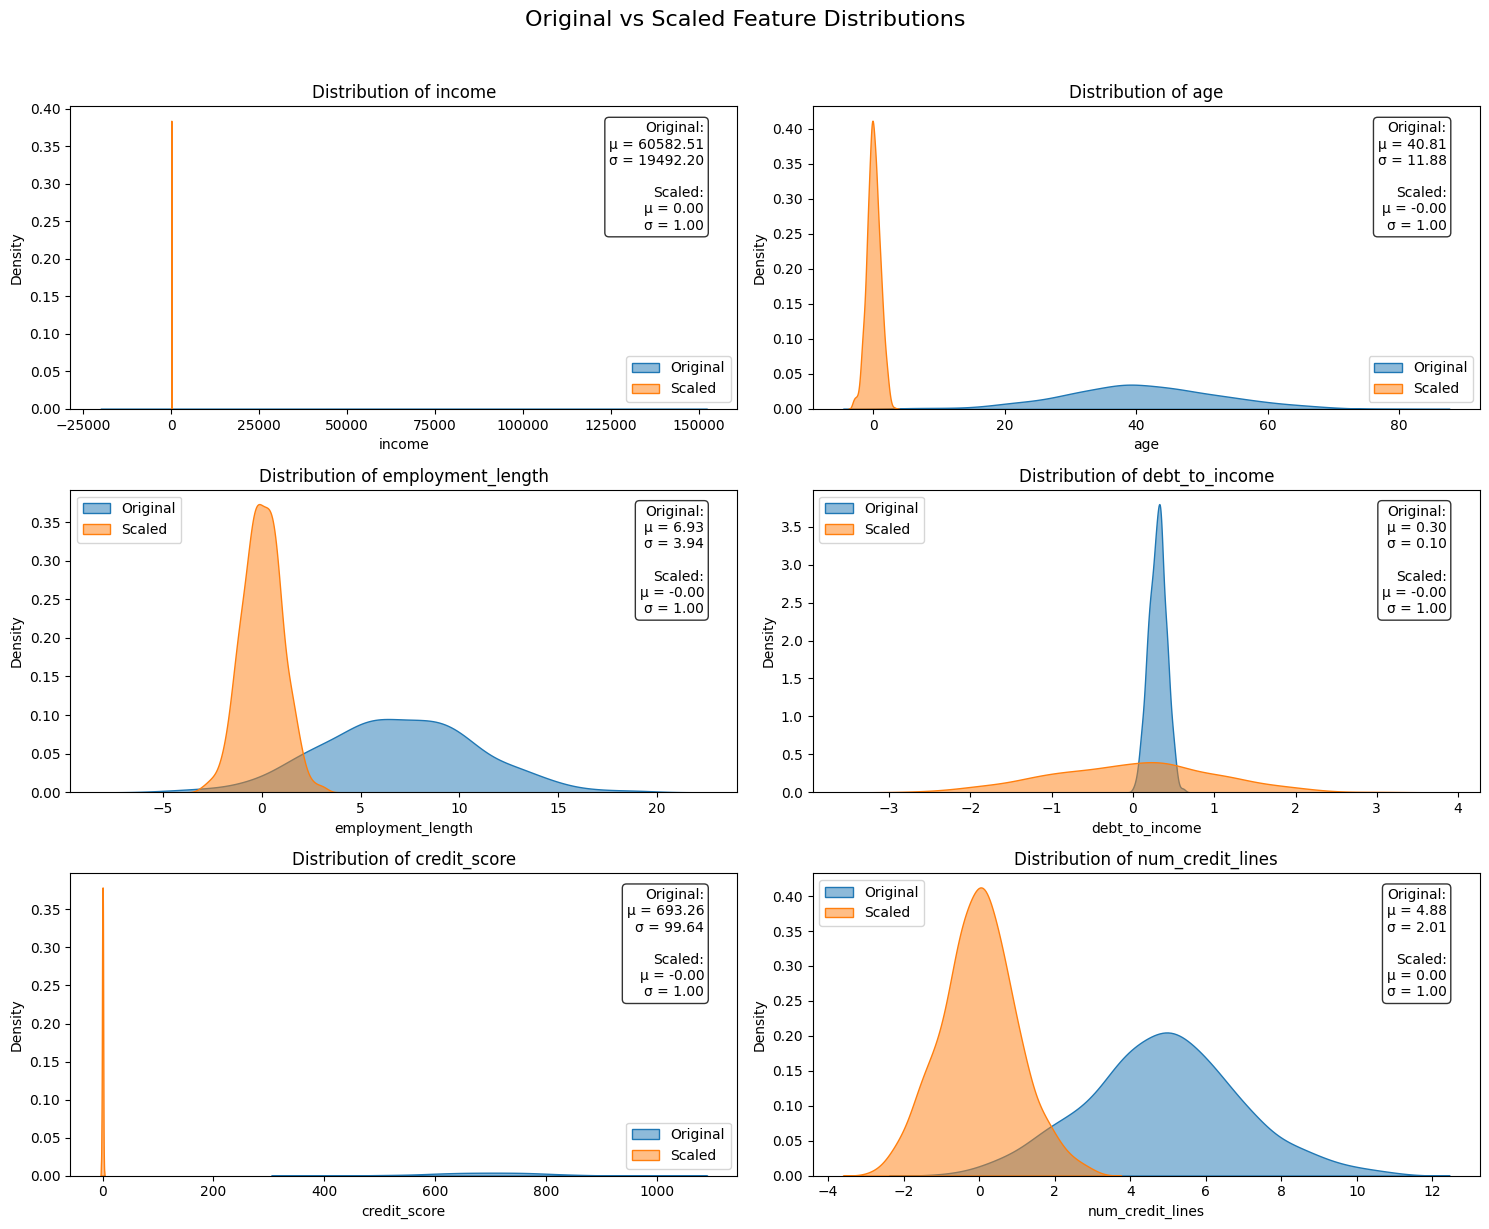


Summary Statistics:

Original Data:
          income     age  employment_length  debt_to_income  credit_score  \
count     800.00  800.00             800.00          800.00        800.00   
mean    60582.51   40.81               6.93            0.30        693.26   
std     19492.20   11.88               3.94            0.10         99.64   
min     -4825.35    4.72              -5.08            0.01        382.33   
25%     46959.34   32.78               4.37            0.23        629.92   
50%     60753.28   40.43               6.95            0.30        696.25   
75%     73188.82   48.50               9.57            0.37        761.14   
max    137054.63   78.32              19.44            0.62       1011.29   

       num_credit_lines  
count            800.00  
mean               4.88  
std                2.01  
min               -0.80  
25%                3.60  
50%                4.94  
75%                6.15  
max               10.87  

Scaled Data:
       income     age

In [18]:
# Convert scaled array back to DataFrame with feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Create a figure with subplots for each feature
n_features = X_train.shape[1]
n_rows = (n_features + 1) // 2  # Number of rows needed
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4*n_rows))
fig.suptitle('Original vs Scaled Feature Distributions', fontsize=16, y=1.02)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Color palettes for original and scaled data
original_color = '#1f77b4'
scaled_color = '#ff7f0e'

# Plot KDE for each feature
for i, feature in enumerate(X_train.columns):
    ax = axes_flat[i]
    
    # Plot original data
    sns.kdeplot(data=X_train[feature], 
                fill=True, 
                alpha=0.5, 
                color=original_color,
                label='Original',
                ax=ax)
    
    # Plot scaled data
    sns.kdeplot(data=X_train_scaled_df[feature], 
                fill=True, 
                alpha=0.5, 
                color=scaled_color,
                label='Scaled',
                ax=ax)
    
    ax.set_title(f'Distribution of {feature}')
    ax.legend()
    
    # Add text box with statistics
    stats_text = f'Original:\nμ = {X_train[feature].mean():.2f}\nσ = {X_train[feature].std():.2f}\n\n' + \
                 f'Scaled:\nμ = {X_train_scaled_df[feature].mean():.2f}\nσ = {X_train_scaled_df[feature].std():.2f}'
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove any empty subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nOriginal Data:")
print(X_train.describe().round(2))
print("\nScaled Data:")
print(X_train_scaled_df.describe().round(2))

## Train models

In [22]:
# Train Logistic Regression Model with balanced class weights
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Train Decision Tree Model with balanced class weights
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

## Visualize the results: Logistic Regression
How to Understand Logistic Regression Visualizations: A Comprehensive Guide

### 1. ROC (Receiver Operating Characteristic) Curve

#### What It Shows
- Plots True Positive Rate (Sensitivity) vs False Positive Rate (1-Specificity) at various classification thresholds
- The diagonal line represents random chance (AUC = 0.5)
- Area Under Curve (AUC) measures overall model discrimination

#### How to Interpret
- **Perfect Model**: Curve reaches top-left corner (AUC = 1.0)
- **Good Model**: Curve significantly above diagonal (AUC > 0.7)
- **Poor Model**: Curve close to diagonal (AUC ≈ 0.5)

#### Business Context
- In credit risk: Balance between missing defaults (FN) and unnecessarily rejecting good customers (FP)

### 2. Precision-Recall Curve
#### What It Shows
- Plots Precision (TP/(TP+FP)) vs Recall (TP/(TP+FN))
- Focuses on positive class performance

#### How to Interpret
- **High Precision**: Few false positives
- **High Recall**: Few false negatives
- **Trade-off**: Usually can't maximize both

#### Business Context
- Better than ROC for imbalanced datasets (e.g., rare defaults)
- Choose operating point based on business priorities:
  - High Precision: When false positives are costly
  - High Recall: When missing positives is costly

### 3. Probability Distributions by Class
#### What It Shows
- Distribution of predicted probabilities for each class
- Degree of separation between classes

#### How to Interpret
- **Well-Separated**: Clear gap between distributions
- **Overlapping**: Model uncertainty in middle range
- **Shape**: Indicates model confidence patterns

#### Business Context
- Helps set probability thresholds for decision-making
- Identifies "grey area" cases needing human review

### 4. Feature Importance Plot
#### What It Shows
- Magnitude and direction of feature coefficients
- Relative importance of each predictor

#### How to Interpret
- **Positive Coefficients**: Increase default probability
- **Negative Coefficients**: Decrease default probability
- **Magnitude**: Relative impact on log-odds

#### Business Context
- Guides feature selection and data collection priorities
- Helps explain decisions to stakeholders
- Validates business intuition about risk factors

### 5. Decision Boundary Visualization (2D)
#### What It Shows
- How model separates classes in feature space
- Probability contours for classification

#### How to Interpret
- **Clear Separation**: Distinct regions for each class
- **Fuzzy Boundaries**: Areas of uncertainty
- **Linear Boundary**: Characteristic of logistic regression

#### Business Context
- Visualizes interaction between key features
- Identifies regions of high/low risk
- Helps understand model limitations

### 6. Correlation Matrix with Predictions
#### What It Shows
- Relationships between features and predictions
- Feature multicollinearity
- Prediction-feature associations

#### How to Interpret
- **Strong Correlations**: Potential redundancy
- **Weak Correlations**: Potentially complementary features
- **Prediction Correlations**: Feature predictive power

#### Business Context
- Guides feature engineering
- Identifies redundant data collection
- Validates expected relationships

### Key Metrics to Consider

#### Classification Metrics
```
Accuracy = (TP + TN) / Total
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
```

#### Business Metrics
```
Approval Rate = (TN + FP) / Total
Default Detection Rate = TP / (TP + FN)
False Approval Rate = FP / (TN + FP)
```

### Common Patterns to Watch For

1. **Overfitting Signs**:
   - Perfect separation in training data
   - Large coefficients
   - Unstable predictions

2. **Underfitting Signs**:
   - Similar probabilities for different cases
   - Poor separation in probability distributions
   - Low AUC

3. **Data Quality Issues**:
   - Unexpected feature importances
   - Counterintuitive correlations
   - Extreme probabilities

### Actionable Insights

1. **Model Improvement**:
   - Feature selection based on importance
   - Threshold optimization using ROC/PR curves
   - Handling of edge cases identified in distributions

2. **Business Process**:
   - Set review thresholds based on probability distributions
   - Allocate resources based on prediction confidence
   - Update underwriting criteria based on feature importance

3. **Risk Management**:
   - Identify high-risk segments from decision boundaries
   - Set monitoring triggers based on probability thresholds
   - Define override criteria for boundary cases

In [27]:
def plot_roc_curve(model, X_test, y_test):
    """Plot ROC curve with AUC score"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test):
    """Plot Precision-Recall curve"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def plot_probability_distributions(model, X_test, y_test):
    """Plot probability distributions for each class"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    plt.figure(figsize=(10, 6))
    for label in [0, 1]:
        mask = y_test == label
        plt.hist(y_pred_proba[mask], bins=30, alpha=0.5, 
                label=f'Class {label}', density=True)
    
    plt.xlabel('Predicted Probability of Default')
    plt.ylabel('Density')
    plt.title('Probability Distributions by Class')
    plt.legend()
    plt.show()

def plot_feature_importance(model, feature_names):
    """Plot feature importance with confidence intervals"""
    coef = model.coef_[0]
    
    # Sort coefficients by absolute value
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title('Feature Importance in Logistic Regression')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.show()

def plot_decision_boundary_2d(model, X, y, feature1_idx, feature2_idx, feature_names):
    """Plot decision boundary for two selected features"""
    # Extract the two features we want to plot
    X_subset = X[:, [feature1_idx, feature2_idx]]
    
    # Create a mesh grid
    x_min, x_max = X_subset[:, 0].min() - 0.5, X_subset[:, 0].max() + 0.5
    y_min, y_max = X_subset[:, 1].min() - 0.5, X_subset[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Create a new logistic regression model with just these two features
    model_2d = LogisticRegression(random_state=42)
    model_2d.fit(X_subset, y)
    
    # Make predictions on the mesh grid
    Z = model_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Plot the contour
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_subset[y == 0][:, 0], X_subset[y == 0][:, 1], 
               c='blue', label='Class 0', alpha=0.6)
    plt.scatter(X_subset[y == 1][:, 0], X_subset[y == 1][:, 1], 
               c='red', label='Class 1', alpha=0.6)
    plt.xlabel(feature_names[feature1_idx])
    plt.ylabel(feature_names[feature2_idx])
    plt.title('Decision Boundary')
    plt.legend()
    plt.show()

ROC Curve:


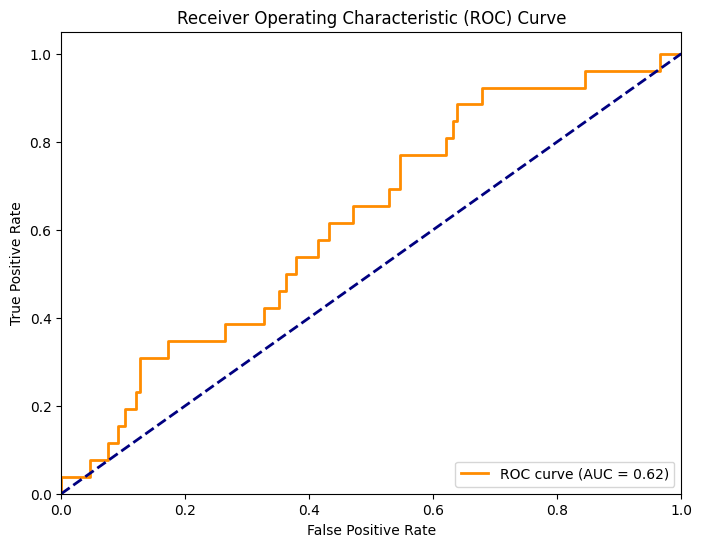


Precision-Recall Curve:


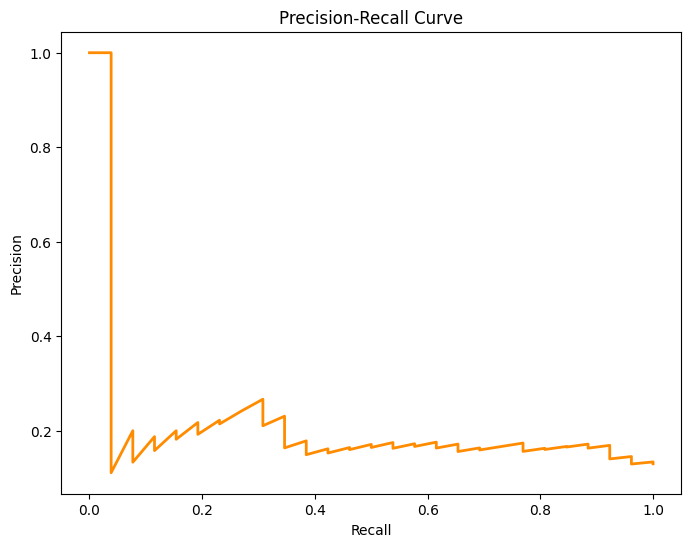


Probability Distributions:


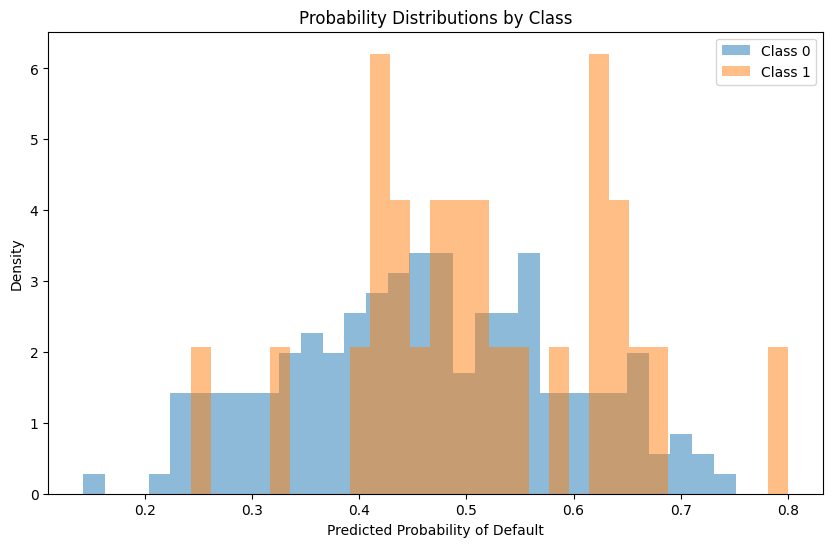


Feature Importance:


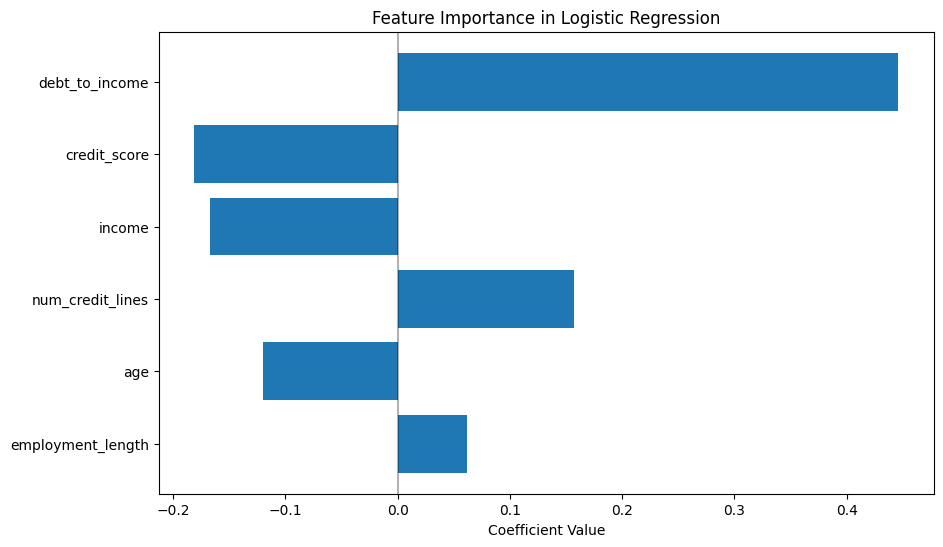


Decision Boundary (2D projection):


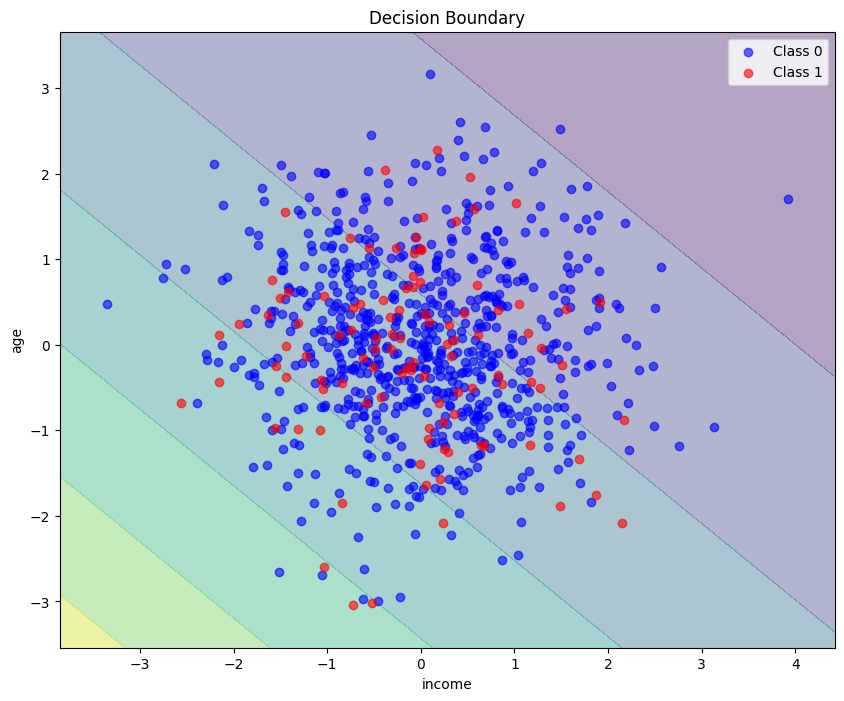

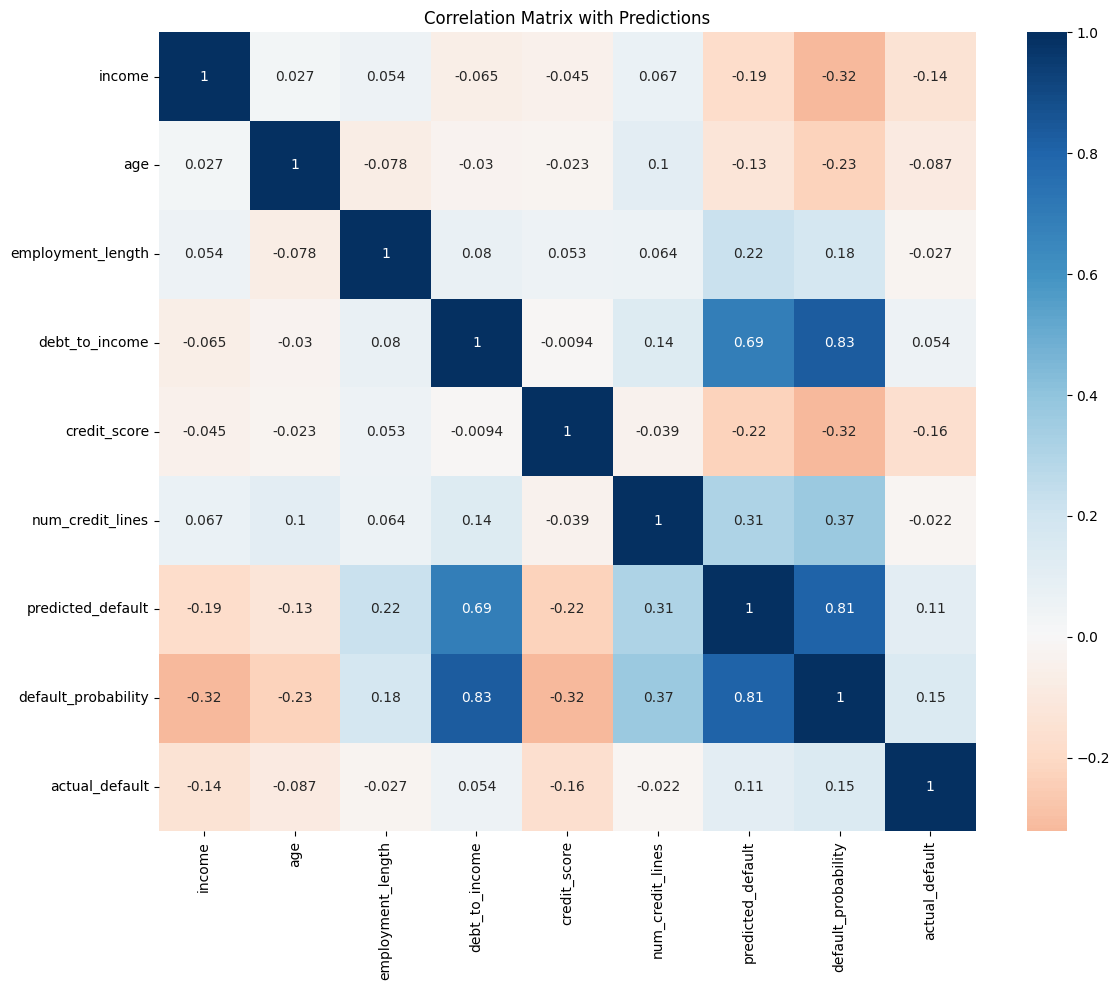


Model Coefficients:
             Feature  Coefficient  Abs_Coefficient
3     debt_to_income     0.446109         0.446109
4       credit_score    -0.181523         0.181523
0             income    -0.167396         0.167396
5   num_credit_lines     0.157181         0.157181
1                age    -0.120275         0.120275
2  employment_length     0.061364         0.061364


In [30]:
# Assuming we have our model and data from previous code
# Let's create all visualizations

# 1. ROC Curve
print("ROC Curve:")
plot_roc_curve(lr_model, X_test_scaled, y_test)

# 2. Precision-Recall Curve
print("\nPrecision-Recall Curve:")
plot_precision_recall_curve(lr_model, X_test_scaled, y_test)

# 3. Probability Distributions
print("\nProbability Distributions:")
plot_probability_distributions(lr_model, X_test_scaled, y_test)

# 4. Feature Importance
print("\nFeature Importance:")
plot_feature_importance(lr_model, X.columns)

# 5. Decision Boundary (using first two features)
print("\nDecision Boundary (2D projection):")
plot_decision_boundary_2d(lr_model, X_train_scaled, y_train, 0, 1, X.columns)

# 6. Correlation Matrix with Predictions
# Get predictions and probabilities
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Create correlation matrix including predictions
X_test_with_pred = X_test.copy()
X_test_with_pred['predicted_default'] = y_pred
X_test_with_pred['default_probability'] = y_pred_proba
X_test_with_pred['actual_default'] = y_test

plt.figure(figsize=(12, 10))
sns.heatmap(X_test_with_pred.corr(), annot=True, cmap='RdBu', center=0)
plt.title('Correlation Matrix with Predictions')
plt.tight_layout()
plt.show()

# Print model coefficients with feature names
print("\nModel Coefficients:")
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)
print(coef_df)

## Visualize Classification Tree


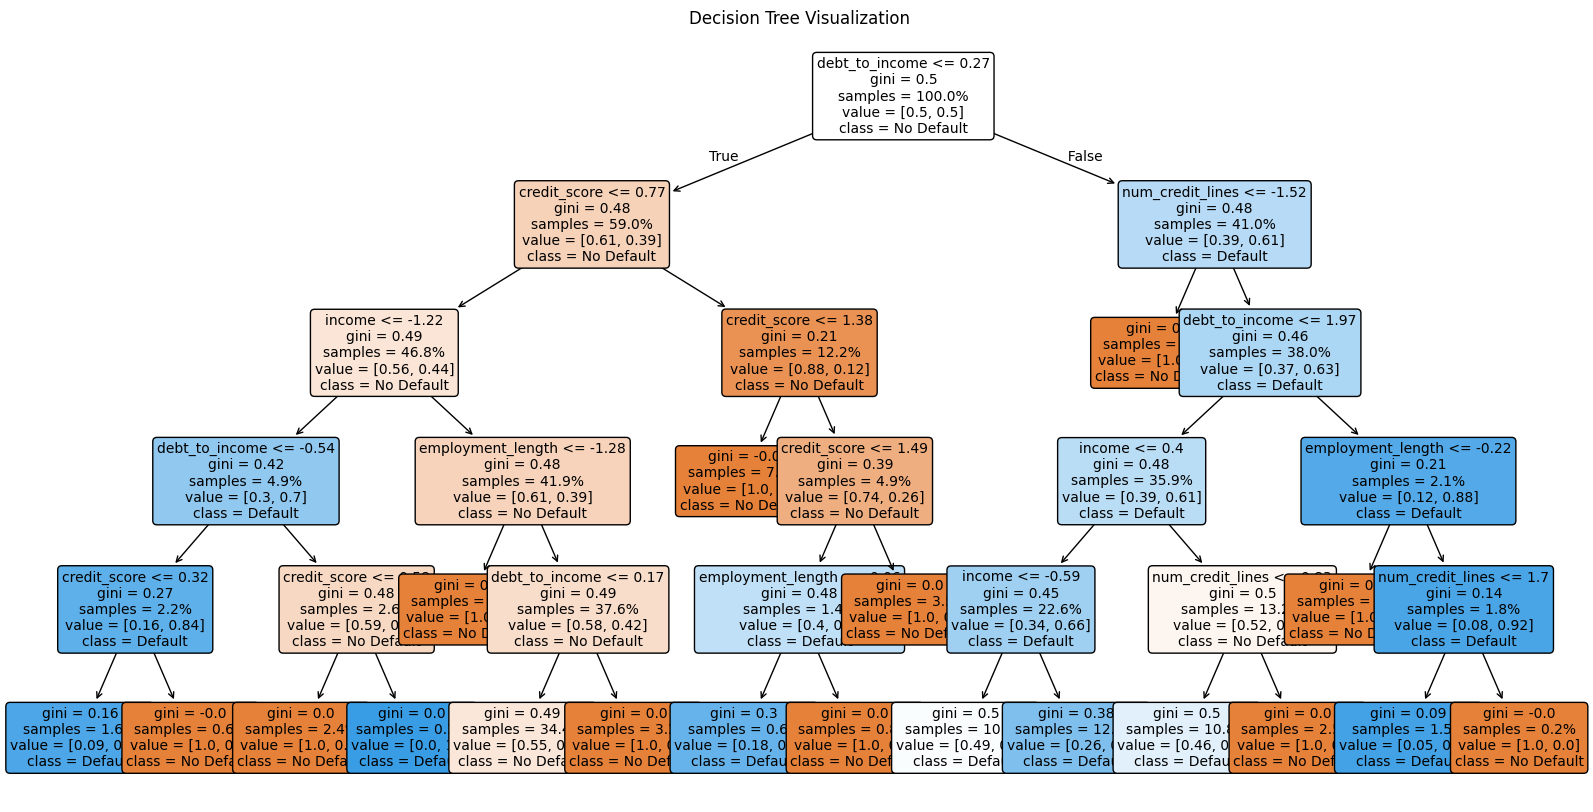

In [34]:
plt.figure(figsize=(20,10))
tree_plot = plot_tree(dt_model, 
                     feature_names=X.columns,
                     class_names=['No Default', 'Default'],
                     filled=True, 
                     rounded=True,
                     fontsize=10,
                     proportion=True,
                     precision=2)
plt.title("Decision Tree Visualization")
plt.show()

### How to Interpret a Decision Tree for Credit Risk Assessment

### 1. Basic Tree Structure Components

#### Root Node
- The top node that includes all data
- Represents the most important split
- Shows the initial class distribution

```
Example Interpretation:
If you see "debt_to_income <= X" at the root:
- This is the most influential factor in determining default risk
- First major decision point in risk assessment
```

#### Internal Nodes
- Represent decision points
- Show feature and threshold for splitting
- Include class distribution for that subset


#### Business Interpretation
1. Follow path from top to bottom
2. Each split creates more specific customer segments
3. Final probability indicates risk level for that segment

### 2. Key Interpretation Aspects

#### A. Feature Importance
1. **Position in Tree**
   - Higher = More important
   - Root node = Most critical factor

2. **Frequency of Use**
   - Features appearing multiple times
   - Different thresholds for different segments

#### B. Threshold Values
1. **Business Context**
```
credit_score <= 650:
- Industry standard cutoff
- Regulatory considerations
- Historical performance benchmark
```

2. **Split Quality**
```
Pure Split Example:
Parent: [50% Default, 50% No Default]
Left Child: [90% No Default]
Right Child: [80% Default]
→ Effective separation of risk groups
```

#### C. Sample Sizes
1. **Node Volumes**
   - Larger samples = More reliable predictions
   - Small leaves might indicate overfitting

2. **Class Distribution**
```
Example:
Node with 1000 samples
- 980 No Default
- 20 Default
→ Strong confidence in low-risk prediction
```


## Evaluate model performances and compare


Logistic Regression Performance Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.73       174
           1       0.17      0.54      0.26        26

    accuracy                           0.61       200
   macro avg       0.54      0.58      0.50       200
weighted avg       0.81      0.61      0.67       200



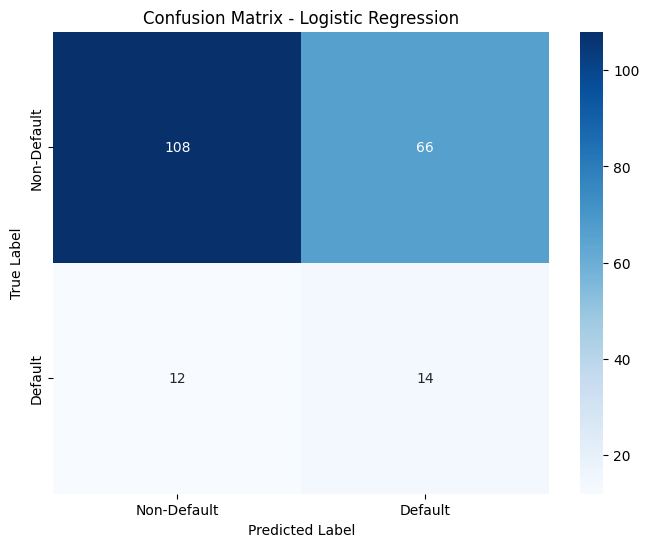


Decision Tree Performance Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       174
           1       0.17      0.42      0.24        26

    accuracy                           0.66       200
   macro avg       0.53      0.56      0.51       200
weighted avg       0.80      0.66      0.71       200



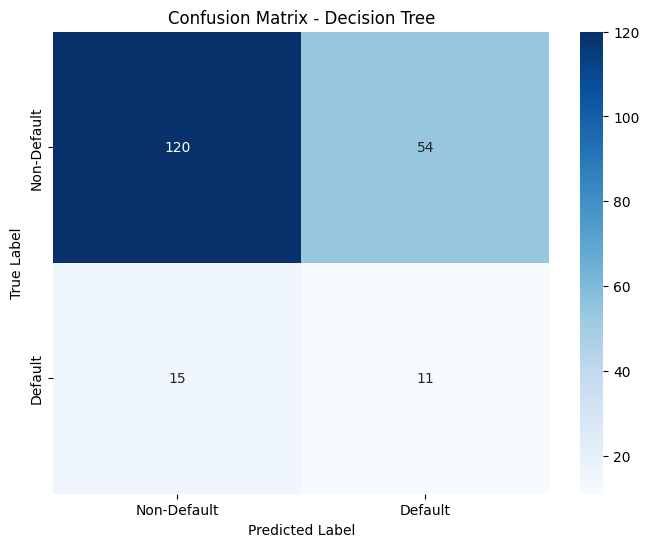

In [39]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model performance with multiple metrics
    """
    predictions = model.predict(X_test)
    print(f"\n{model_name} Performance Metrics:")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    
    # Create confusion matrix heatmap with explicit labels
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, predictions, labels=[0, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Default', 'Default'],
                yticklabels=['Non-Default', 'Default'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate both models
evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
evaluate_model(dt_model, X_test_scaled, y_test, "Decision Tree")

def plot_feature_importance(model, feature_names, model_name):
    """
    Plot feature importance for the given model
    """
    plt.figure(figsize=(10, 6))
    
    if isinstance(model, LogisticRegression):
        importance = np.abs(model.coef_[0])
    else:  # Decision Tree
        importance = model.feature_importances_
    
    features_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=True)
    
    plt.barh(range(len(importance)), features_df['importance'])
    plt.yticks(range(len(importance)), features_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()

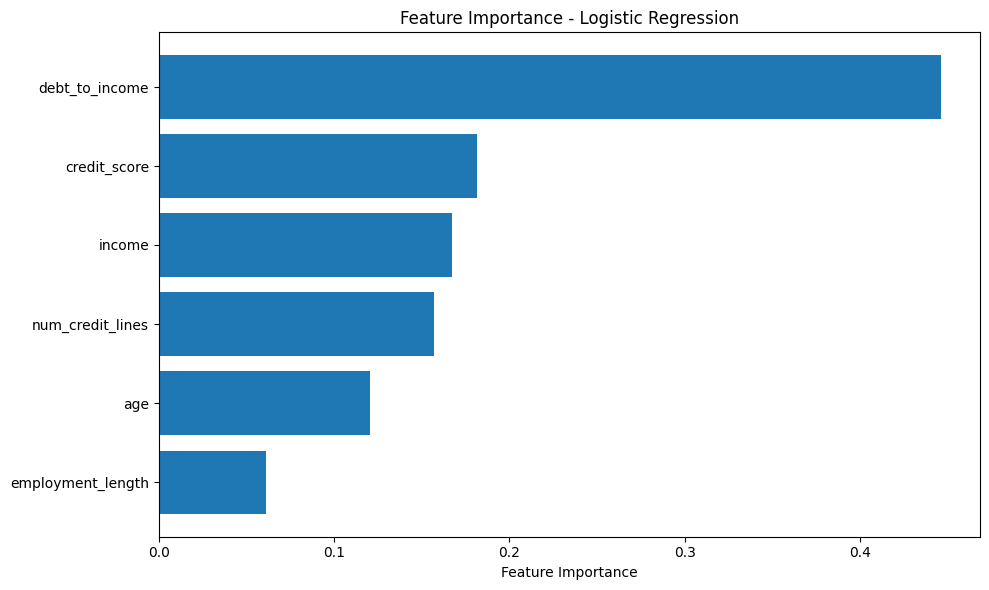

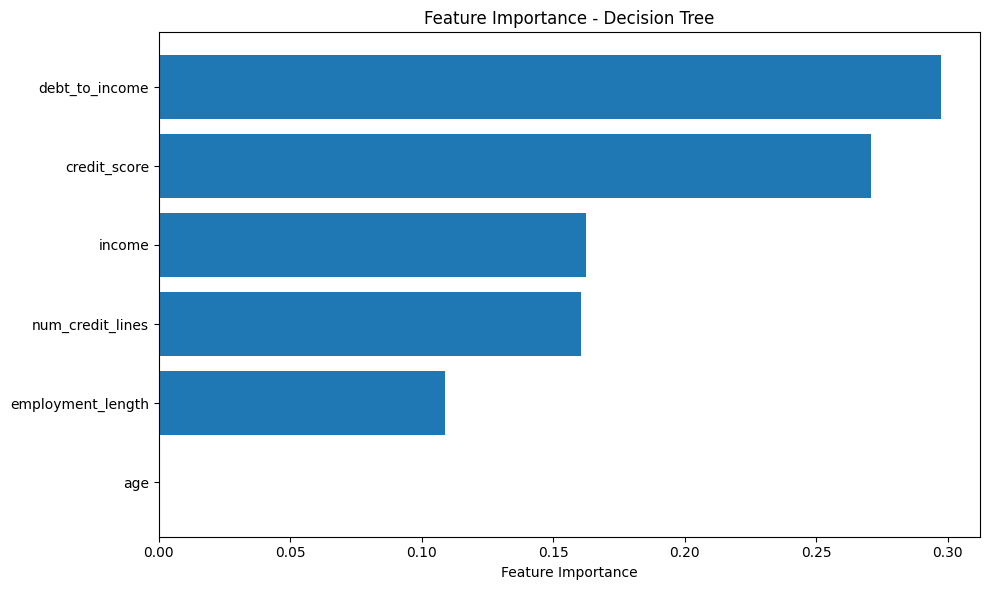

In [42]:
# Plot feature importance for both models
plot_feature_importance(lr_model, X.columns, "Logistic Regression")
plot_feature_importance(dt_model, X.columns, "Decision Tree")

## Predict/Forecast
Based on the current client data of defaults and client characteristic, you have trained classification models (to classify applicants into 'default' or 'no default' classes or groups). Use characteristics of a new customer or client to predict his or her probability (class) of default:

In [46]:
def predict_credit_risk(model, scaler, applicant_data):
    """
    Predict credit risk for new applicants
    """
    # Scale the applicant data
    applicant_scaled = scaler.transform(applicant_data)
    
    # Get prediction and probability
    prediction = model.predict(applicant_scaled)
    probability = model.predict_proba(applicant_scaled)
    
    return prediction, probability

In [49]:
# Example usage for new applicant
new_applicant = pd.DataFrame({
    'income': [75000],
    'age': [35],
    'employment_length': [8],
    'debt_to_income': [0.25],
    'credit_score': [720],
    'num_credit_lines': [4]
})

prediction, probability = predict_credit_risk(lr_model, scaler, new_applicant)
print("\nNew Applicant Risk Assessment:")
print(f"Prediction: {'Default' if prediction[0] == 1 else 'Non-Default'}")
print(f"Probability of Default: {probability[0][1]:.2%}")


New Applicant Risk Assessment:
Prediction: Non-Default
Probability of Default: 38.18%


**Play around**: How would your prediction change if you vary some of the characteristic of a new client? Say a very young client, with bad credit score, no income and lots of debt???

In [53]:
# Example usage for new applicant
new_applicant = pd.DataFrame({
    'income': [5000],
    'age': [18],
    'employment_length': [0],
    'debt_to_income': [0.95],
    'credit_score': [420],
    'num_credit_lines': [10]
})

prediction, probability = predict_credit_risk(lr_model, scaler, new_applicant)
print("\nNew Applicant Risk Assessment:")
print(f"Prediction: {'Default' if prediction[0] == 1 else 'Non-Default'}")
print(f"Probability of Default: {probability[0][1]:.2%}")


New Applicant Risk Assessment:
Prediction: Default
Probability of Default: 98.48%


**Try**: Loan default prediction for the new client is done based on Logistic Regression you pre-trained earlier (model `lr_model`). How does your predicition chnage based on your pre-trained Tree-based model, `dt_model`, for thew same client(s)?